In [1]:
import plotly
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as pximport 
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
systematic_noise_df = pd.read_csv('output/systematic_errors_experimental_output.csv')
random_noise_df = pd.read_csv('output/random_errors_experimental_output.csv')
denoise_df = pd.read_csv('output/denoised_model_output.csv')

In [4]:
def plot_after_sorting(x_col, y_col, data):
    
    x, y = data[x_col], data[y_col]
#     lists = sorted(itertools.izip(*[x, y]))
#     new_x, new_y = list(itertools.izip(*lists))
    new_x, new_y = zip(*sorted(zip(x, y)))
    
    plt.plot(new_x, new_y)
    plt.show()

In [5]:
def reorder_for_plotting(x_col, y_col, data):
    x, y = data[x_col], data[y_col]
    new_x, new_y = zip(*sorted(zip(x, y)))
    
    return new_x, new_y

In [7]:
# our Worker F1 and test accuracy are all decimals, whereas model metrics are not. 
# we need to multiply Worker metrics by 100 for consistency. 

systematic_noise_df['worker_avg_f1'] = systematic_noise_df['worker_avg_f1'] * 100
systematic_noise_df['test_accuracy'] = systematic_noise_df['test_accuracy'] * 100

random_noise_df['worker_avg_f1'] = random_noise_df['worker_avg_f1'] * 100
random_noise_df['test_accuracy'] = random_noise_df['test_accuracy'] * 100

denoise_df['worker_avg_f1'] = denoise_df['worker_avg_f1'] * 100
denoise_df['test_accuracy'] = denoise_df['test_accuracy'] * 100

In [8]:
systematic_noise_df

,noise_prop,worker_avg_f1,worker_std_f1,test_accuracy,model_precision,model_recall,model_f1
0,0.00,61.120755,0.171028,92.720299,69.36,57.22,62.71
1,0.05,58.149813,0.161298,92.513921,65.46,56.83,60.84
2,0.10,55.133730,0.154124,92.644367,68.36,56.49,61.86
3,0.15,52.236663,0.141128,92.453565,65.79,55.30,60.09
4,0.20,49.270560,0.137251,92.340641,63.29,57.05,60.01
5,0.25,47.138666,0.123668,92.200459,62.98,55.45,58.97
6,0.30,42.814831,0.122359,92.402944,66.69,53.73,59.51
7,0.35,40.381686,0.111775,92.348429,68.93,54.59,60.93
8,0.40,38.045306,0.095625,91.548226,58.13,50.77,54.20
9,0.45,34.415568,0.093500,88.804953,30.59,33.36,31.92


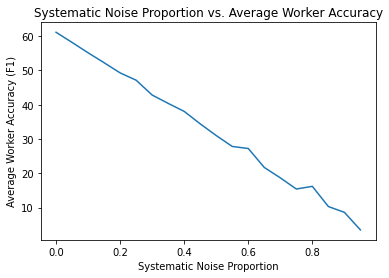

In [9]:
x, y = reorder_for_plotting('noise_prop', 'worker_avg_f1', data=systematic_noise_df)
plt.plot(x, y)
plt.xlabel('Systematic Noise Proportion')
# plt.xlim(0, 1)
plt.ylabel('Average Worker Accuracy (F1)')
# plt.ylim(0, 1)
plt.title('Systematic Noise Proportion vs. Average Worker Accuracy')
plt.show()

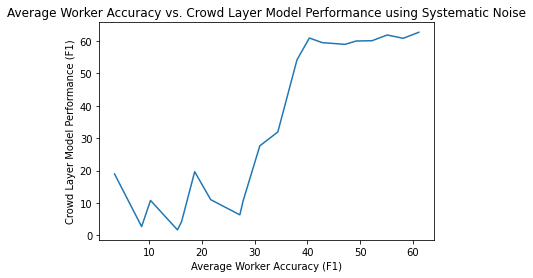

In [10]:
x, y = reorder_for_plotting('worker_avg_f1', 'model_f1', data=systematic_noise_df)
plt.plot(x, y)
plt.xlabel('Average Worker Accuracy (F1)')
# plt.xlim(0, 1)
plt.ylabel('Crowd Layer Model Performance (F1)')
# plt.ylim(0, 1)
plt.title('Average Worker Accuracy vs. Crowd Layer Model Performance using Systematic Noise')
plt.show()

In [11]:
random_noise_df

,noise_prop,worker_avg_f1,worker_std_f1,test_accuracy,model_precision,model_recall,model_f1
0,0.00,61.120755,0.171028,92.681360,67.09,57.38,61.86
1,0.05,58.583171,0.165050,92.523656,65.43,57.80,61.38
2,0.10,56.235467,0.154945,92.254974,63.85,55.08,59.14
3,0.15,53.285024,0.150795,92.457459,67.03,55.21,60.55
4,0.20,50.747299,0.139760,92.535337,65.20,55.87,60.17
5,0.25,48.317329,0.134821,92.171255,64.74,54.10,58.94
6,0.30,45.392401,0.125644,92.260815,66.34,54.55,59.87
7,0.35,43.091911,0.117261,91.980452,64.86,50.24,56.62
8,0.40,40.710350,0.108909,92.062225,63.80,53.49,58.19
9,0.45,37.940647,0.103949,91.929831,64.66,50.40,56.64


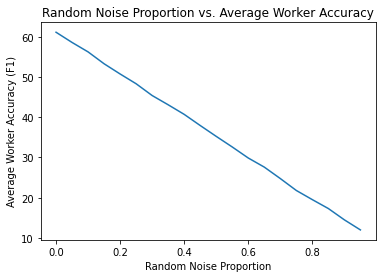

In [12]:
x, y = reorder_for_plotting('noise_prop', 'worker_avg_f1', data=random_noise_df)
plt.plot(x, y)
plt.xlabel('Random Noise Proportion')
# plt.xlim(0, 1)
plt.ylabel('Average Worker Accuracy (F1)')
# plt.ylim(0, 1)
plt.title('Random Noise Proportion vs. Average Worker Accuracy')
plt.show()

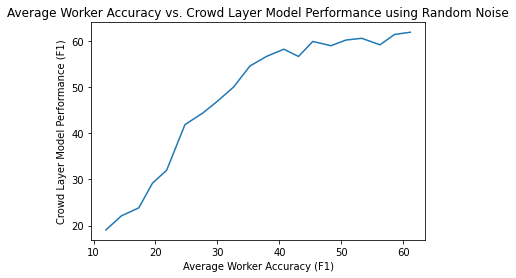

In [13]:
x, y = reorder_for_plotting('worker_avg_f1', 'model_f1', data=random_noise_df)
plt.plot(x, y)
plt.xlabel('Average Worker Accuracy (F1)')
# plt.xlim(0, 1)
plt.ylabel('Crowd Layer Model Performance (F1)')
# plt.ylim(0, 1)
plt.title('Average Worker Accuracy vs. Crowd Layer Model Performance using Random Noise')
plt.show()

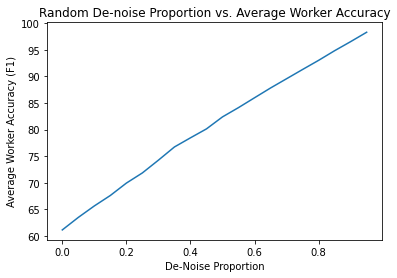

In [15]:
x, y = reorder_for_plotting('noise_prop', 'worker_avg_f1', data=denoise_df)
plt.plot(x, y)
plt.xlabel('De-Noise Proportion')
# plt.xlim(0, 1)
plt.ylabel('Average Worker Accuracy (F1)')
# plt.ylim(0, 1)
plt.title('Random De-noise Proportion vs. Average Worker Accuracy')
plt.show()

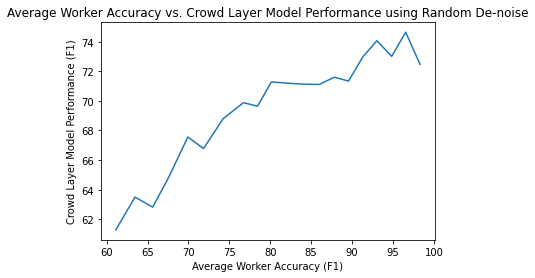

In [16]:
x, y = reorder_for_plotting('worker_avg_f1', 'model_f1', data=denoise_df)
plt.plot(x, y)
plt.xlabel('Average Worker Accuracy (F1)')
# plt.xlim(0, 1)
plt.ylabel('Crowd Layer Model Performance (F1)')
# plt.ylim(0, 1)
plt.title('Average Worker Accuracy vs. Crowd Layer Model Performance using Random De-noise')
plt.show()

In [17]:
random_noise_combined_df = random_noise_df.append(denoise_df, ignore_index=True)

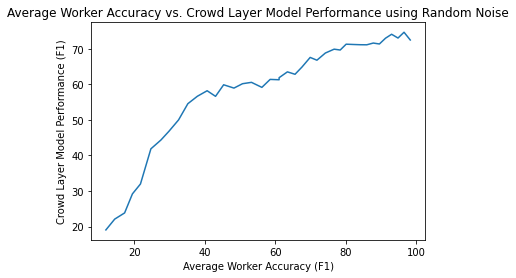

In [19]:
x, y = reorder_for_plotting('worker_avg_f1', 'model_f1', data=random_noise_combined_df)
plt.plot(x, y)
plt.xlabel('Average Worker Accuracy (F1)')
# plt.xlim(0, 1)
plt.ylabel('Crowd Layer Model Performance (F1)')
# plt.ylim(0, 1)
plt.title('Average Worker Accuracy vs. Crowd Layer Model Performance using Random Noise')
plt.show()